## Figure 5

In [36]:
device = "cuda:0"

import pandas as pd
import pickle
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../model')
from utils import amino_acid_to_number, tokenize, Tee
from functions import get_A2N_list, tokenize, make_train_val_test_lists_rand, prepare_data
from models import make_predictions, ProtDataset, Transformer_2k, LinearModel


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [37]:
def get_r_stat(df, norm=None):
    df_ = df.copy()
    df__ = df.copy()
    for i in range(4): 
        df_.iloc[:, i] = df_.iloc[:, :i + 1].max(1) 
    for m in [1, 2, 3]:
        diffs = (df_.iloc[:, m].to_numpy() - df_.iloc[:, m - 1].to_numpy())
        res_r2 = (1 - df_.iloc[:, 0].to_numpy())
        epi_r2 = (df_.iloc[:, -1].to_numpy() - df_.iloc[:, 0].to_numpy())
        res_8_r2 = (1 - df.max(1))
        if norm == 'res':
            df__.iloc[:, m] = diffs/res_r2
        elif norm == 'epi':
            df__.iloc[:, m] = diffs/epi_r2
        else: 
            df__.iloc[:, m] = diffs
    df__[df__ < 0] = 0
    
    return df__

def make_even(df):
    df_ = pd.DataFrame(index=df.index, 
                       columns=df.columns)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            if df.iloc[i, j] < df.iloc[i, :j].max():
                df_.iloc[i, j] = df.iloc[i, :j].max()
            else: df_.iloc[i, j] = df.iloc[i, j]
    return df_

def get_delta_r2(result):
    output = {k:{} for k in result.keys()}
    for rep in range(len(output)):
        result_rep = dict(make_even(pd.DataFrame(result[rep])))
        for i in range(1, 4):
            r = pd.Series(result_rep[models[i]]) - pd.Series(result_rep[models[i - 1]])
            r[r < 0] = 0
            output[rep][models[i]] = r
    return output

In [38]:
model_names = ["Linear", "Pairwise", "4-th Order", "8-th Order"]

### AAV2

In [39]:
import torch.utils.data as data
data_name = 'Sinai2021'
in_path = "../Data/Data_prepared/" + data_name + ".csv"
datafile = pd.read_csv(in_path, index_col=None)
phenotypes, seqs, seqs1h = prepare_data(datafile)
n, L, AA_size = seqs1h.shape

seqs_ex = seqs + AA_size*torch.tensor(range(L))
X = seqs_ex.to(device)
y = phenotypes.to(device)
seqs1hf = seqs1h.reshape(n, -1).to(device).float()

results_paths = ["../results/Sinai2021_Random_20.0%/"]

nrep = len(results_paths)
r2_by_d_model_rep = {}
preds_rep = {}

for i in range(nrep):
    results_path = results_paths[i]
    with open(results_path + "train_list.pkl", 'rb') as file:
        train_list = pickle.load(file)

    comp_list = set(range(n)).difference(train_list)
    comp_list = list(comp_list)
    test_list = comp_list
    X_test, y_test = X[test_list], y[test_list]
    test_dataset = ProtDataset(X_test, y_test)
    test_loader = data.DataLoader(test_dataset,
                                batch_size=500,
                                shuffle=False,
                                drop_last=False)
    preds = {}
    for model_name  in ["TF_1_BestModel", "TF_2_BestModel", "TF_3_BestModel"]:
        print(model_name)
        model_best = torch.load(results_path + model_name)
        model_best.eval()
        pred, _ = make_predictions(model_best, test_loader)
        preds[model_name] = pred

    for model_name in ["Linear_BestModel"]:
        X__ = seqs1h.float().to(device)
        X_test, y_test = X__[test_list], y[test_list]
        test_dataset = ProtDataset(X_test, y_test)
        test_loader = data.DataLoader(test_dataset,
                                    batch_size=500,
                                    shuffle=False,
                                    drop_last=False)

        model_best = torch.load(results_path + model_name)
        pred, true = make_predictions(model_best, test_loader)
        preds[model_name] = pred
    
    preds_rep[i] = preds

TF_1_BestModel
TF_2_BestModel
TF_3_BestModel


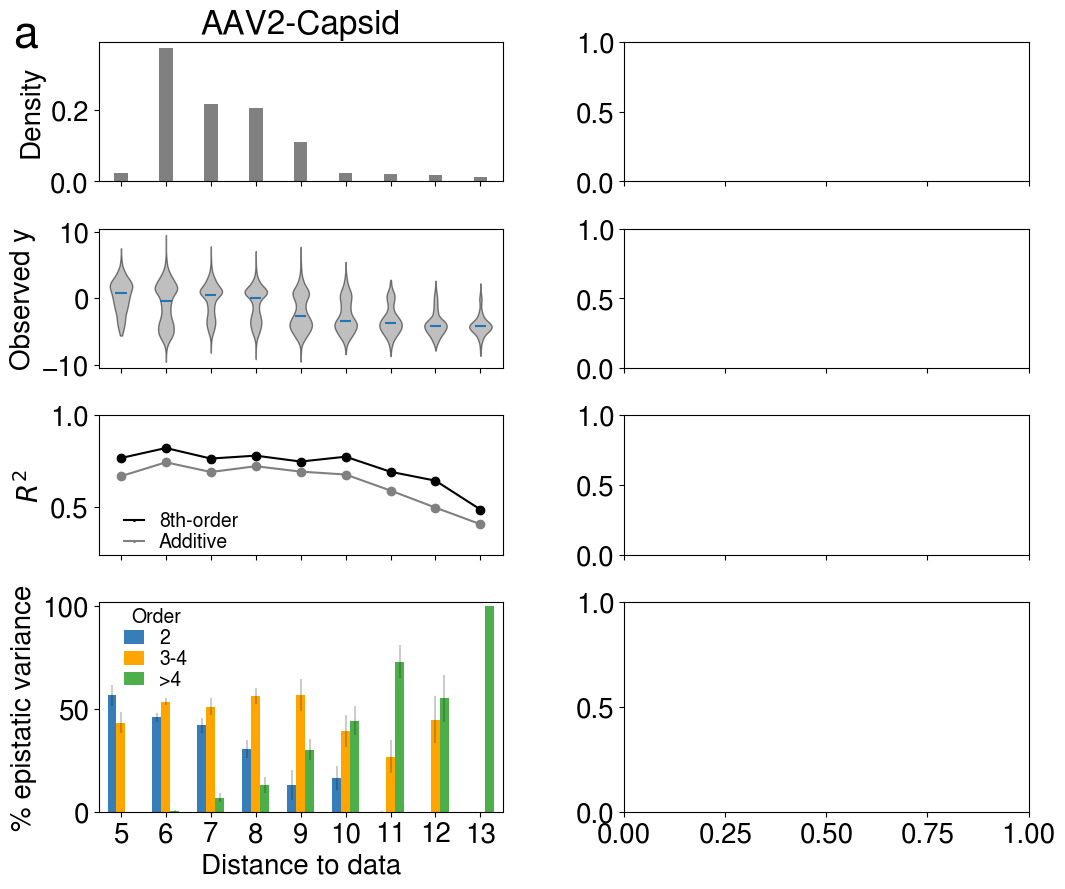

In [40]:
step_size = 1
comp_list = set(range(n)).difference(train_list)
comp_list = list(comp_list)
diff = L - seqs1hf[comp_list].matmul(seqs1hf[train_list].T)
meandiff = diff.mean(1)
meandiff = meandiff.cpu().detach().numpy()
dist_bins = np.array([int(x) for x in meandiff / step_size])
d_classes = list(set(dist_bins))

distances = np.array(d_classes) * step_size
ndists = 9

models = ['Linear_BestModel', 'TF_1_BestModel', 'TF_2_BestModel', 'TF_3_BestModel']

import random
nrep = 10
for i in range(nrep):
    random.seed(i)
    r2_by_d_model = {}
    for model_name in models:
        r2_by_d = {}
        for d in distances[:ndists]:
            pos = np.where(dist_bins == d/step_size)[0]
            pos = random.sample(list(pos), int(.9*(len(pos))))
            r2_by_d[d] = pearsonr(preds_rep[0][model_name][pos], true[pos])[0]**2
            
        r2_by_d_model[model_name] = r2_by_d
    
    r2_by_d_model_rep[i] = r2_by_d_model

diffs_by_rep = {}

for i in range(nrep):
    df = pd.DataFrame(r2_by_d_model_rep[i])
    diffs_by_rep[i] = get_r_stat(df, norm='epi')
    

dist_chosen = distances[:ndists]

plotdata = {model_id:{} for model_id in ['Pairwise', '4-th order', '8-th order']}
dic = {'Pairwise':1, '4-th order':2, '8-th order':3}

for model_id in ['Pairwise', '4-th order', '8-th order']:
    df = pd.DataFrame({i: diffs_by_rep[i].iloc[:, dic[model_id]] for i in range(nrep)})
    values = df.mean(1)[dist_chosen]
    errors = df.std(1)[dist_chosen]
    plotdata[model_id] = {'values': values, 'errors': errors}


dataset_name = "AAV2-Capsid"

plotdat_add = pd.DataFrame({i: pd.Series(r2_by_d_model_rep[i]['Linear_BestModel']) for i in range(nrep)})
plotdat_epi = pd.DataFrame({i: pd.Series(r2_by_d_model_rep[i]['TF_3_BestModel']) for i in range(nrep)})


plt.rcParams.update({'font.size': 20})
plt.rcParams['font.family'] =  'Nimbus Sans'

colors = ['gray', '#377eb8',  'orange', '#4daf4a']

fontsize = 20
plt.rcParams.update({'font.size': fontsize})
plt.rcParams['font.family'] =  'Nimbus Sans'
plt.rcParams["legend.markerscale"] = .2
fig, axs = plt.subplots(4, 2, figsize=(12, 10), width_ratios = [1, 1], 
                        height_ratios = [1, 1, 1, 1.5], gridspec_kw={'hspace': 0.3, 'wspace': .3},
                        sharex='col')

dist_list = dist_bins * step_size
dist_list = dist_list[dist_list <= dist_chosen[-1]]
axs[0, 0].hist(dist_list, bins=np.arange(min(dist_list), max(dist_list) + 1.5) - 0.5, 
            edgecolor=None, rwidth=.3, color='gray', density=True)
axs[0, 0].set_ylabel('Density')
axs[0, 0].set_title(dataset_name)


data = {d: datafile.iloc[comp_list][dist_bins == d].DMS_score for d in dist_chosen}
data = [data[key] for key in data]

parts = axs[1, 0].violinplot(data, positions=dist_chosen, showmeans=False, showmedians=True, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(.5)

axs[1, 0].set_ylabel('Observed y')

positions = dist_chosen
plotdat_add = pd.DataFrame({i: pd.Series(r2_by_d_model_rep[i]['Linear_BestModel']) for i in range(nrep)})
plotdat_epi = pd.DataFrame({i: pd.Series(r2_by_d_model_rep[i]['TF_3_BestModel']) for i in range(nrep)})


axs[2, 0].plot(dist_chosen, 
               plotdat_epi.mean(1), 
               color='black', label='8th-order', 
               marker='o', linestyle='-')
axs[2, 0].plot(dist_chosen, 
               plotdat_add.mean(1), 
               color='gray', label='Additive', 
               marker='o', linestyle='-')

axs[2, 0].set_ylabel("$R^2$")
axs[2, 0].set_ylim(0.24, 1)
legend = axs[2, 0].legend(loc='lower left', 
                          bbox_to_anchor=(0.02, -.1), 
                          fontsize=14, 
                          frameon=False, 
                          labelspacing=0.1, 
                          handlelength=1.0
                         )

bar_width = .2
legs = {'Pairwise': '2', '4-th order': '3-4', '8-th order': ">4"}

# Plot bars with error bars
for i, cls in enumerate(plotdata.keys()):
    values = plotdata[cls]['values']  # get values for the class
    errors = plotdata[cls]['errors']  # get errors for the class
    axs[3, 0].bar([p + (i - 1) * bar_width for p in positions], 
                  100 * values, 
                  yerr= 100 * errors,                   
                  width=bar_width, 
                  label=legs[cls], 
                  color=colors[i + 1],
                  capsize=0, 
                  error_kw={'alpha': 0.2})

    
axs[3, 0].set_ylabel('% epistatic variance')
axs[3, 0].set_xlim(dist_chosen[0] - .5, dist_chosen[-1] + .5)
axs[3, 0].set_ylim(0, 102)
axs[3, 0].set_yticks([0, 50, 100])
legend = axs[3, 0].legend(loc='lower left', 
                          bbox_to_anchor=(0.02, .5),
                          fontsize=14, 
                          frameon=False, 
                          labelspacing=0.1, 
                          handlelength=1.0)
legend.set_title("Order", prop={'size': 14})
plt.setp(legend.get_title(), multialignment='center')


axs[3, 0].set_xticks(dist_chosen)
axs[3, 0].set_xlabel('Distance to data')


axs[0, 0].text(-0.15, 1.2, 'a', transform=axs[0, 0].transAxes,
        fontsize=fontsize + 12, va='top', ha='right')

plt.show()

### cgreGFP new

In [48]:
import torch.utils.data as data
datafile = pd.read_csv("../Data/Data_prepared/Somermeyer2022_cgreGFP.csv")
                    
phenotypes, seqs, seqs1h = prepare_data(datafile)
n, L, AA_size = seqs1h.shape

seqs1hf = seqs1h.reshape(-1, AA_size*L)
seqs1hf = seqs1hf.to(device).float()

seqs_ex = seqs + AA_size*torch.tensor(range(L))
X = seqs_ex.to(device)
y = phenotypes.to(device)

results_paths = ['../results/Somermeyer2022_cgreGFP_Random_20.0%/']
nrep = len(results_paths)

r2_by_d_model_rep = {}
preds_rep = {}

for i in range(nrep):
    results_path = results_paths[i]
    with open(results_path + "train_list.pkl", 'rb') as file:
        train_list = pickle.load(file)

    comp_list = set(range(n)).difference(train_list)
    comp_list = list(comp_list)
    test_list = comp_list
    X_test, y_test = X[test_list], y[test_list]
    test_dataset = ProtDataset(X_test, y_test)
    test_loader = data.DataLoader(test_dataset,
                                batch_size=500,
                                shuffle=False,
                                drop_last=False)
    preds = {}
    for model_name  in ["TF_1_BestModel", "TF_2_BestModel", "TF_3_BestModel"]:
    # for model_name  in ["TF_1_BestModel"]:    
        print(model_name)
        model_best = torch.load(results_path + model_name)
        model_best.eval()
        pred, _ = make_predictions(model_best, test_loader)
        preds[model_name] = pred

    for model_name in ["Linear_BestModel"]:
        X__ = seqs1h.float().to(device)
        X_test, y_test = X__[test_list], y[test_list]
        test_dataset = ProtDataset(X_test, y_test)
        test_loader = data.DataLoader(test_dataset,
                                    batch_size=500,
                                    shuffle=False,
                                    drop_last=False)

        model_best = torch.load(results_path + model_name)
        pred, true = make_predictions(model_best, test_loader)
        preds[model_name] = pred
    
    preds_rep[i] = preds

TF_1_BestModel
TF_2_BestModel
TF_3_BestModel


In [49]:
step_size = 1
comp_list = set(range(n)).difference(train_list)
comp_list = list(comp_list)
diff = L - seqs1hf[comp_list].matmul(seqs1hf[train_list].T)
meandiff = diff.mean(1)
meandiff = meandiff.cpu().detach().numpy()
dist_bins = np.array([int(x) for x in meandiff / step_size])
d_classes = list(set(dist_bins))

distances = np.array(d_classes) * step_size

distances = distances[1:]

n_dists = 5

In [50]:
models = ['Linear_BestModel', 'TF_1_BestModel', 'TF_2_BestModel', 'TF_3_BestModel']

import random
nrep = 10
for i in range(nrep):
    random.seed(i)
    r2_by_d_model = {}
    for model_name in models:
        r2_by_d = {}
        for d in distances[:n_dists]:
            pos = np.where(dist_bins == d/step_size)[0]
            pos = random.sample(list(pos), int(.9*(len(pos))))
            r2_by_d[d] = pearsonr(preds_rep[0][model_name][pos], true[pos])[0]**2
            
        r2_by_d_model[model_name] = r2_by_d
    
    r2_by_d_model_rep[i] = r2_by_d_model

In [51]:
diffs_by_rep = {}

for i in range(nrep):
    df = pd.DataFrame(r2_by_d_model_rep[i])
    diffs_by_rep[i] = get_r_stat(df, norm='epi')

In [52]:
dist_chosen = distances[:n_dists]

In [53]:
plotdata = {model_id:{} for model_id in ['Pairwise', '4-th order', '8-th order']}
dic = {'Pairwise':1, '4-th order':2, '8-th order':3}

for model_id in ['Pairwise', '4-th order', '8-th order']:
    df = pd.DataFrame({i: diffs_by_rep[i].iloc[:, dic[model_id]] for i in range(nrep)})
    values = df.mean(1)[dist_chosen]
    errors = df.std(1)[dist_chosen]
    plotdata[model_id] = {'values': values, 'errors': errors}

In [54]:
dataset_name = "cgreGFP"

In [55]:
dist_min = 4
dist_list = dist_bins * step_size
dist_list = dist_list[(dist_list <= dist_chosen[-1]) & (dist_list > dist_min)]
axs[0, 1].hist(dist_list, bins=np.arange(min(dist_list), max(dist_list) + 1.5) - 0.5, 
            edgecolor=None, rwidth=.3, color='gray', density=True)
axs[0, 1].set_ylabel('Density')
axs[0, 1].set_title(dataset_name)


data = {d: datafile.iloc[comp_list][dist_bins == d].DMS_score for d in dist_chosen}
data = [data[key] for key in data]

parts = axs[1, 1].violinplot(data, positions=dist_chosen, showmeans=False, showmedians=True, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(.5)

axs[1, 1].set_ylabel('Observed y')

positions = dist_chosen
plotdat_add = pd.DataFrame({i: pd.Series(r2_by_d_model_rep[i]['Linear_BestModel']) for i in range(nrep)})
plotdat_epi = pd.DataFrame({i: pd.Series(r2_by_d_model_rep[i]['TF_3_BestModel']) for i in range(nrep)})


axs[2, 1].plot(dist_chosen, 
               plotdat_add.mean(1), 
               color='gray', 
               marker='o', linestyle='-')

axs[2, 1].plot(dist_chosen, 
               plotdat_epi.mean(1), 
               color='black', 
               marker='o', linestyle='-')

axs[2, 1].set_ylabel("$R^2$")
axs[2, 1].set_ylim(0.24, 1)

bar_width = .2
# Plot bars with error bars
for i, cls in enumerate(plotdata.keys()):
    values = plotdata[cls]['values']  # get values for the class
    errors = plotdata[cls]['errors']  # get errors for the class
    axs[3, 1].bar([p + (i - 1) * bar_width for p in positions], 
                  100 * values, 
                  yerr= 100 * errors,                   
                  width=bar_width, 
                  label=cls, 
                  color=colors[i + 1],
                  capsize=0, 
                  error_kw={'alpha': 0.2})

    
axs[3, 1].set_ylabel('% epistatic variance')
axs[3, 1].set_xlim(dist_chosen[0] - .5, dist_chosen[-1] + .5)
axs[3, 1].set_ylim(0, 102)
axs[3, 1].set_yticks([0, 50, 100])

axs[3, 1].set_xticks(dist_chosen)
axs[3, 1].set_xlabel('Distance to data')


axs[0, 1].text(-0.1, 1.2, 'b', transform=axs[0, 1].transAxes,
        fontsize=fontsize + 12, va='top', ha='right')

plt.show()

In [117]:
fig.savefig("../figures/AAV2-cgreGFP-HD_v2.pdf", bbox_inches='tight')

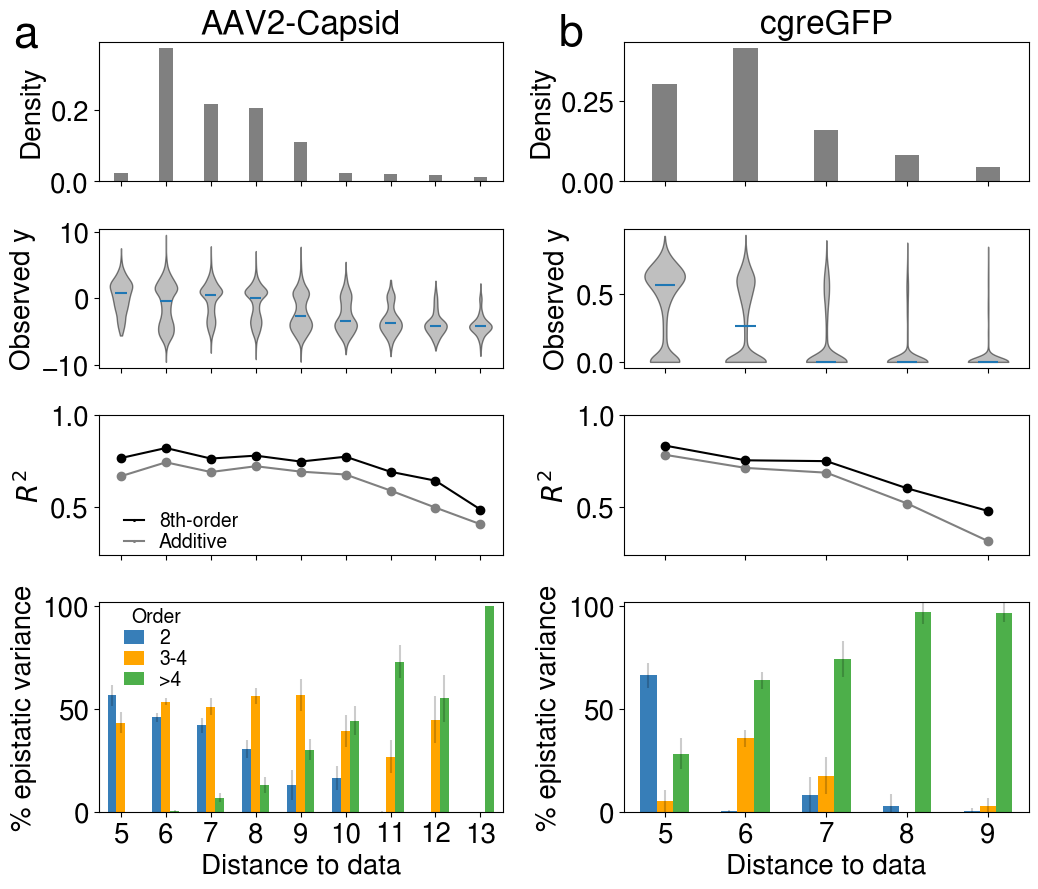

In [56]:
fig

## Supplemental Figure 6

In [17]:
import torch.utils.data as data
datafile = pd.read_csv("../Data/Data_prepared/Pokusaeva_2019_S5.csv")

                    
phenotypes, seqs, seqs1h = prepare_data(datafile)
n, L, AA_size = seqs1h.shape

seqs1hf = seqs1h.reshape(-1, AA_size*L)
seqs1hf = seqs1hf.to(device).float()

seqs_ex = seqs + AA_size*torch.tensor(range(L))
X = seqs_ex.to(device)
y = phenotypes.to(device)

results_paths = ['/blue/juannanzhou/palash.sethi/Projects/ProteinLLEs/ProteinLLE_v4/output/Pokusaeva_2019_S5_Random_20.0%_rep_0/']
nrep = len(results_paths)

r2_by_d_model_rep = {}
preds_rep = {}

for i in range(nrep):
    results_path = results_paths[i]
    with open(results_path + "train_list.pkl", 'rb') as file:
        train_list = pickle.load(file)

    comp_list = set(range(n)).difference(train_list)
    comp_list = list(comp_list)
    test_list = comp_list
    X_test, y_test = X[test_list], y[test_list]
    test_dataset = ProtDataset(X_test, y_test)
    test_loader = data.DataLoader(test_dataset,
                                batch_size=500,
                                shuffle=False,
                                drop_last=False)
    preds = {}
    for model_name  in ["TF_1_BestModel", "TF_2_BestModel", "TF_3_BestModel"]:
    # for model_name  in ["TF_1_BestModel"]:    
        print(model_name)
        model_best = torch.load(results_path + model_name)
        model_best.eval()
        pred, _ = make_predictions(model_best, test_loader)
        preds[model_name] = pred

    for model_name in ["Linear_BestModel"]:
        X__ = seqs1h.float().to(device)
        X_test, y_test = X__[test_list], y[test_list]
        test_dataset = ProtDataset(X_test, y_test)
        test_loader = data.DataLoader(test_dataset,
                                    batch_size=500,
                                    shuffle=False,
                                    drop_last=False)

        model_best = torch.load(results_path + model_name)
        pred, true = make_predictions(model_best, test_loader)
        preds[model_name] = pred
    
    preds_rep[i] = preds

TF_1_BestModel
TF_2_BestModel
TF_3_BestModel


In [18]:
step_size = 1
comp_list = set(range(n)).difference(train_list)
comp_list = list(comp_list)
diff = L - seqs1hf[comp_list].matmul(seqs1hf[train_list].T)
meandiff = diff.mean(1)
meandiff = meandiff.cpu().detach().numpy()
dist_bins = np.array([int(x) for x in meandiff / step_size])
d_classes = list(set(dist_bins))

distances = np.array(d_classes) * step_size

n_dists = 5

In [19]:
d_classes

[9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [20]:
models = ['Linear_BestModel', 'TF_1_BestModel', 'TF_2_BestModel', 'TF_3_BestModel']

import random
nrep = 10
for i in range(nrep):
    random.seed(i)
    r2_by_d_model = {}
    for model_name in models:
    # for model_name  in ["TF_1_BestModel"]:        
        r2_by_d = {}
        for d in distances[:n_dists]:
            pos = np.where(dist_bins == d/step_size)[0]
            pos = random.sample(list(pos), int(.9*(len(pos))))
            r2_by_d[d] = pearsonr(preds_rep[0][model_name][pos], true[pos])[0]**2
            
        r2_by_d_model[model_name] = r2_by_d
    
    r2_by_d_model_rep[i] = r2_by_d_model

In [21]:
diffs_by_rep = {}

for i in range(nrep):
    df = pd.DataFrame(r2_by_d_model_rep[i])
    diffs_by_rep[i] = get_r_stat(df, norm='epi')

/scratch/local/42195879/ipykernel_2842944/674550248.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2
/scratch/local/42195879/ipykernel_2842944/674550248.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2
/scratch/local/42195879/ipykernel_2842944/674550248.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2
/scratch/local/42195879/ipykernel_2842944/674550248.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2
/scratch/local/42195879/ipykernel_2842944/674550248.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2
/scratch/local/42195879/ipykernel_2842944/674550248.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2
/scratch/local/42195879/ipykernel_2842944/674550248.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs

In [22]:
dist_chosen = distances[:n_dists]

In [23]:
plotdata = {model_id:{} for model_id in ['Pairwise', '4-th order', '8-th order']}
dic = {'Pairwise':1, '4-th order':2, '8-th order':3}

for model_id in ['Pairwise', '4-th order', '8-th order']:
    df = pd.DataFrame({i: diffs_by_rep[i].iloc[:, dic[model_id]] for i in range(nrep)})
    values = df.mean(1)[dist_chosen]
    errors = df.std(1)[dist_chosen]
    plotdata[model_id] = {'values': values, 'errors': errors}

In [24]:
dataset_name = "cgreGFP"

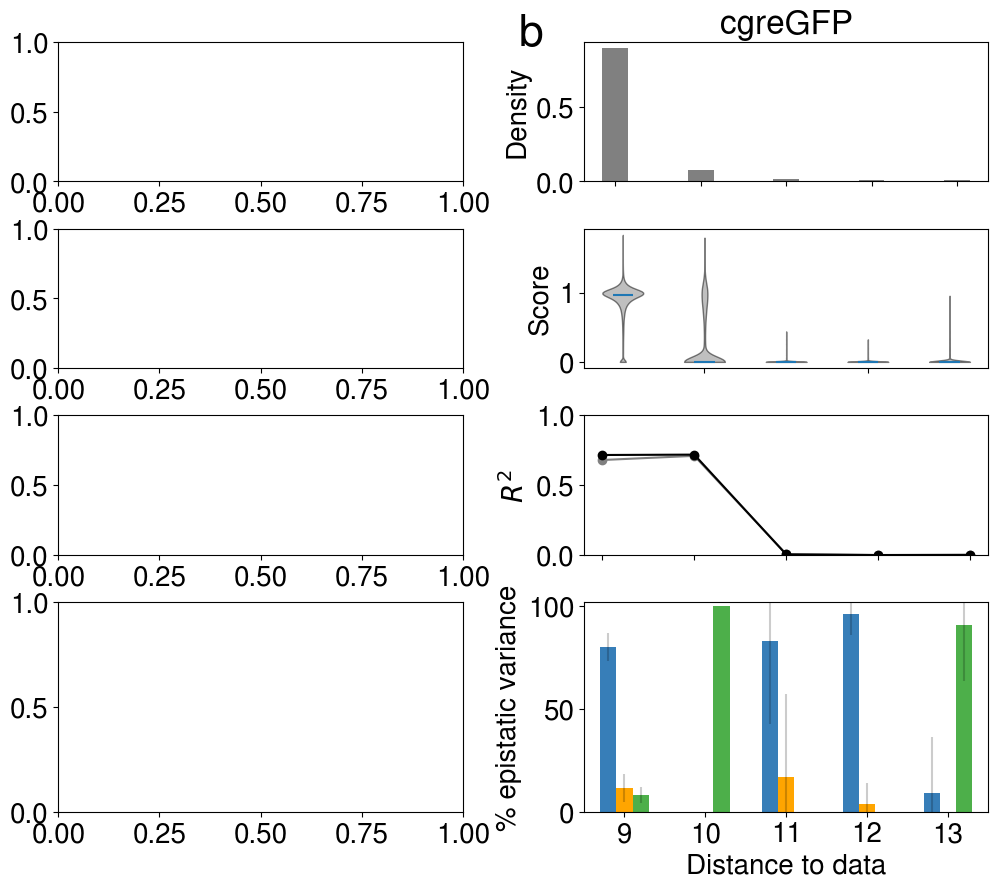

In [25]:
colors = ['gray', '#377eb8',  'orange', '#4daf4a']
fontsize = 20
plt.rcParams.update({'font.size': fontsize})
plt.rcParams['font.family'] =  'Nimbus Sans'
plt.rcParams["legend.markerscale"] = .2
fig, axs = plt.subplots(4, 2, figsize=(12, 10), width_ratios = [1, 1], 
                        height_ratios = [1, 1, 1, 1.5], gridspec_kw={'hspace': 0.3, 'wspace': .3},
                       sharex=False)


dist_min = 4
dist_list = dist_bins * step_size
dist_list = dist_list[(dist_list <= dist_chosen[-1]) & (dist_list > dist_min)]
axs[0, 1].hist(dist_list, bins=np.arange(min(dist_list), max(dist_list) + 1.5) - 0.5, 
            edgecolor=None, rwidth=.3, color='gray', density=True)
axs[0, 1].set_xticks(dist_chosen)
axs[0, 1].set_xticklabels([])
axs[0, 1].set_ylabel('Density')
axs[0, 1].set_title(dataset_name)


data = {d: datafile.iloc[comp_list][dist_bins == d].DMS_score for d in dist_chosen}
data = [data[key] for key in data]

parts = axs[1, 1].violinplot(data, positions=dist_chosen, showmeans=False, showmedians=True, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(.5)

axs[1, 1].set_ylabel('Score')
axs[1, 1].set_xticklabels([])

positions = dist_chosen
plotdat_add = pd.DataFrame({i: pd.Series(r2_by_d_model_rep[i]['Linear_BestModel']) for i in range(nrep)})
plotdat_epi = pd.DataFrame({i: pd.Series(r2_by_d_model_rep[i]['TF_3_BestModel']) for i in range(nrep)})


axs[2, 1].plot(dist_chosen, 
               plotdat_add.mean(1), 
               color='gray', 
               marker='o', linestyle='-')

axs[2, 1].plot(dist_chosen, 
               plotdat_epi.mean(1), 
               color='black', 
               marker='o', linestyle='-')

axs[2, 1].set_xticks(dist_chosen)
axs[2, 1].set_xticklabels([])
axs[2, 1].set_ylabel("$R^2$")
axs[2, 1].set_ylim(0., 1)
# axs[2, 0].set_ylim(0.0, .2)
# axs[2, 0].set_yticks([.4, .8])

bar_width = .2
# Plot bars with error bars
for i, cls in enumerate(plotdata.keys()):
    values = plotdata[cls]['values']  # get values for the class
    errors = plotdata[cls]['errors']  # get errors for the class
    axs[3, 1].bar([p + (i - 1) * bar_width for p in positions], 
                  100 * values, 
                  yerr= 100 * errors,                   
                  width=bar_width, 
                  label=cls, 
                  color=colors[i + 1],
                  capsize=0, 
                  error_kw={'alpha': 0.2})

    
axs[3, 1].set_ylabel('% epistatic variance')
axs[3, 1].set_xlim(dist_chosen[0] - .5, dist_chosen[-1] + .5)
axs[3, 1].set_ylim(0, 102)
axs[3, 1].set_yticks([0, 50, 100])
axs[3, 1].set_xticks(dist_chosen)


axs[3, 1].set_xticks(dist_chosen)
axs[3, 1].set_xlabel('Distance to data')


axs[0, 1].text(-0.1, 1.2, 'b', transform=axs[0, 1].transAxes,
        fontsize=fontsize + 12, va='top', ha='right')

plt.show()